## Import libraries


In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
import torch.optim as optim
import csv 
from itertools import product



In [2]:
!nvidia-smi

Fri Jan  5 21:01:34 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:86:00.0 Off |                  N/A |
| 27%   22C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load images and labels

In [3]:
# Function to load images from a folder and convert them to a tensor
def load_images_and_labels(images_path, labels_path):
    df_labels = pd.read_csv(labels_path)
    images_paths = os.listdir(images_path)
    images = []
    labels = []
    for filename in tqdm(images_paths, desc = "Reading images"):
        if filename.endswith(".png"):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img) / 255
            label = df_labels[df_labels['Image'] == filename]['Class'].values[0]
            images.append(img_array)
            labels.append(label)
    labels = np.array(labels)
    images = np.array(images)
    labels_tensor = torch.Tensor(labels)
    images_tensor = torch.Tensor(images)
    return images_tensor, labels_tensor


In [4]:
# Specify the paths
train_images_folder_path = "train_images"
labels_path = "train.csv"

# Load images and labels into tensors
train_images, train_labels = load_images_and_labels(train_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", train_images.shape)
print("Labels Tensor Shape:", train_labels.shape)


Reading images: 100%|██████████| 13000/13000 [01:11<00:00, 181.74it/s]


Images Tensor Shape: torch.Size([13000, 64, 64, 3])
Labels Tensor Shape: torch.Size([13000])


In [5]:
# Specify the paths
val_images_folder_path = "val_images"
labels_path = "val.csv"

# Load images and labels into tensors
val_images, val_labels = load_images_and_labels(val_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", val_images.shape)
print("Labels Tensor Shape:", val_labels.shape)


Reading images: 100%|██████████| 2000/2000 [00:01<00:00, 1330.99it/s]


Images Tensor Shape: torch.Size([2000, 64, 64, 3])
Labels Tensor Shape: torch.Size([2000])


In [6]:
# Specify the paths
test_images_folder_path = "test_images"
labels_path = "predictions4.csv"

# Load images and labels into tensors
test_images, test_labels = load_images_and_labels(test_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", test_images.shape)
print("Labels Tensor Shape:", test_labels.shape)


Reading images: 100%|██████████| 5000/5000 [00:33<00:00, 149.09it/s]


Images Tensor Shape: torch.Size([5000, 64, 64, 3])
Labels Tensor Shape: torch.Size([5000])


## EDA

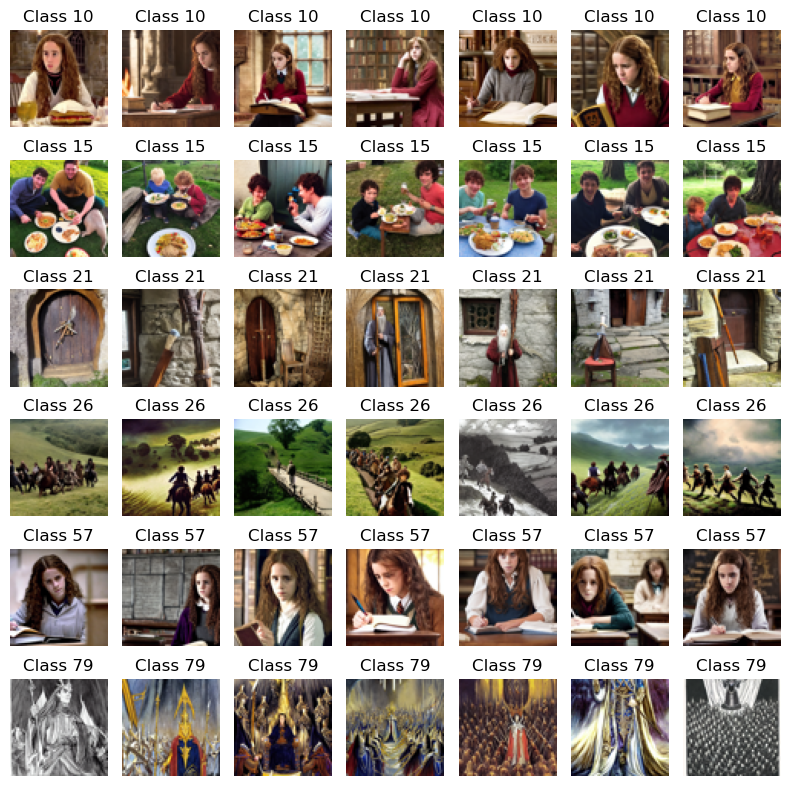

In [7]:
num_examples_to_display = 7
# Create subplots
fig, axes = plt.subplots(6, 7, figsize=(8, 8))

# Flatten the axes to simplify indexing
axes = axes.flatten()
i = 0

for label in [10, 15, 21, 26, 57, 79]:
    indices_in_class = np.where(test_labels == label)[0][:num_examples_to_display]
    for index in indices_in_class:
        example_image = test_images[index, :, :, :].numpy() 
        # print(f"   Example {index}: {example_image.shape}")
        # print(f"   Min value: {example_image.min()}")
        # print(f"   Max value: {example_image.max()}")
        axes[i].imshow(example_image)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].title.set_text(f"Class {label}")
        i += 1
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Dataset

In [6]:
train_images_permuted = train_images.permute((0, 3, 2, 1))
val_images_permuted = val_images.permute((0, 3, 2, 1))

# Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(train_images_permuted, train_labels, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
# X_train = torch.tensor(train_images_permuted, dtype=torch.float32).clone().detach().requires_grad_(True).to('cuda')
# y_train = torch.tensor(train_labels, dtype=torch.int64).clone().detach().to('cuda')
# X_test = torch.tensor(val_images_permuted, dtype=torch.float32).to('cuda')
# y_test = torch.tensor(val_labels, dtype=torch.int64).to('cuda')

X_train = train_images_permuted.clone().detach().requires_grad_(True).to('cuda')
y_train = train_labels.clone().detach().requires_grad_(True).to('cuda')
X_test = val_images_permuted.clone().detach().requires_grad_(True).to('cuda')
y_test = val_labels.clone().detach().requires_grad_(True).to('cuda')



In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([13000, 3, 64, 64]),
 torch.Size([13000]),
 torch.Size([2000, 3, 64, 64]),
 torch.Size([2000]))

## Train functions

In [8]:
def train_model(model, optimizer, X_train, y_train, X_val, y_val, batch_size = 32, num_epochs = 10, save_weights = False, weights_path="weights", last_epoch = 0):
    val_loss_array = []
    val_acc_array = []
    train_loss_array = []
    train_acc_array = []
    
    # Create a DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = model.to('cuda')
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0
    
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda') # Move input data to GPU
            labels = labels.type(torch.LongTensor)
            labels = labels.to('cuda')

            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(inputs)
            # outputs = outputs.view(outputs.size(0), -1) 
            loss = criterion(outputs, labels)
    
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # Calculate train accuracy
            
            # _, predicted = torch.max(outputs, 1)
            # correct_predictions += (predicted == labels.flatten().type(torch.cuda.FloatTensor)).sum().item()
            # predictions = (outputs > 0.5).float()
            predictions = torch.argmax(outputs, dim=1).float()
            correct_predictions += (predictions == labels).sum().item()
            
            total_samples += labels.size(0)
    
        average_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        print(f'Epoch [{last_epoch + epoch + 1}/{last_epoch + num_epochs}], Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy * 100:.2f}%')
        val_loss, val_accuracy = validate(model, X_val, y_val, batch_size, nn.CrossEntropyLoss())
        print(f'Epoch [{last_epoch + epoch + 1}/{last_epoch + num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')
        global max_accuracy
        if save_weights:
            if val_accuracy > max_accuracy:
                torch.save(model.state_dict(), f'weights/{weights_path}_epoch{last_epoch + epoch + 1}.pth')
                print("weights saved")
                max_accuracy = val_accuracy

        val_loss_array.append(val_loss)
        val_acc_array.append(val_accuracy)
        train_loss_array.append(average_loss)
        train_acc_array.append(accuracy)
    return val_loss_array, val_acc_array, train_loss_array, train_acc_array

In [9]:
def validate(model, X, y, batch_size, criterion = nn.CrossEntropyLoss()):
   
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation during validation
        for inputs, labels in data_loader:
            inputs = inputs.to('cuda') # Move input data to GPU
            labels = labels.type(torch.LongTensor)
            labels = labels.to('cuda')

            # Assuming inputs and labels are already on the GPU if using CUDA
            outputs = model(inputs)
            # outputs = outputs.view(outputs.size(0), -1) 
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Convert outputs to binary predictions (0 or 1) based on a threshold (e.g., 0.5 for sigmoid)
            # predictions = (outputs > 0.5).float()
            predictions = torch.argmax(outputs, dim=1).float()
            correct_predictions += (predictions == labels).sum().item()

            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    return average_loss, accuracy


In [10]:
def plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array):
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    epochs = range(1, len(val_loss_array)+1)
    # Plot validation loss
    ax1.plot(epochs, val_loss_array, 'orange', label='Validation Loss')
    ax1.plot(epochs, train_loss_array, 'green',  label='Train Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, val_acc_array, 'orange', label='Validation Accuracy')
    ax2.plot(epochs, train_acc_array, 'green', label='Train Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Models

## Resnet 

In [11]:
# Define the basic block for ResNet
class Block(nn.Module):
    extansion = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_channels != self.extansion * out_channels:
        #     print("reached downsample", in_channels, self.extansion * out_channels)
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, self.extansion * out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.extansion * out_channels)
            # )
        self.downsample = None
        # if is_first_block and stride != 1:
        if stride != 1 or in_channels != self.extansion * out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                      out_channels= out_channels,
                                                      kernel_size=1,
                                                      stride=stride,
                                                      padding=0),
                                            nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x.clone()
        # print("block initial shape:", x.shape)
        x = self.relu(self.bn1(self.conv1(x)))
        # print("block shape after conv1:", x.shape)
        x = self.bn2(self.conv2(x))
        # print("block shape after conv2:", x.shape)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        # print("block shape after residual:", x.shape)
        x = self.relu(x)
        return x


In [12]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], 3, 1, 1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1]*block.extansion, 3, 2, 1)
        self.layer3 = self.make_layer(block, 256, num_blocks[2]*block.extansion, 3, 2, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels * block.extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [13]:
# Define the ResNet model
class ResNet_personalized(nn.Module):
    def __init__(self, block, num_blocks, strides, filters, num_classes=100):
        super(ResNet_personalized, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, filters[0], num_blocks[0], 3, strides[0], 1)
        self.layer2 = self.make_layer(block, filters[1], num_blocks[1]*block.extansion, 3, strides[1], 1)
        self.layer3 = self.make_layer(block, filters[2], num_blocks[2]*block.extansion, 3, strides[2], 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(filters[2] * block.extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels * block.extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [14]:
model = ResNet_personalized(Block, [2, 2, 2], [2, 3, 3], [128, 128, 256])
model = model.to("cuda")
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


### grid search for number of blocks

In [83]:
max_accuracy = 0.76

filters_combinations = list(product([64, 128, 256, 512], repeat=3))
asc_filters_combinations = [comb for comb in filters_combinations if all(comb[i] <= comb[i + 1] for i in range(len(comb) - 1))]

param_grid = {
    'nr_blocks_layer1': range(1, 6),  
    'nr_blocks_layer2': range(1, 6),
    'nr_blocks_layer3': range(1, 6),
    'strides': list(product([1,2,3], repeat=3)),
    'filters': asc_filters_combinations
}

# Randomly sample hyperparameter combinations
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Iterate over sampled hyperparameter combinations
for params in param_list:
    l1 = params['nr_blocks_layer1']
    l2 = params['nr_blocks_layer2']
    l3 = params['nr_blocks_layer3']
    strides = params['strides']
    filters = params['filters']

    model = ResNet_personalized(Block, [l1, l2, l3], strides, filters)
    model = model.to('cuda')
    optimizer = optim.SGD(model.parameters(), lr = 0.026, momentum = 0.755)
    weights_name = f"resnet_pers_blocks-{l1}-{l2}-{l3}_strides={strides}_filters={filters}"
    print(f"=== Train with blocks {l1}, {l2}, {l3}, strides={strides}, filters={filters} ===\n")
    _, val_acc, _, _ = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = weights_name)

    # Print the current hyperparameters and their corresponding accuracy
    print(f"Blocks {l1}, {l2}, {l3}, strides={strides}, filters={filters}")
    # Adjust the printed information based on your specific evaluation metric
    accuracy = max(val_acc)
    print(f"Validation Accuracy: {accuracy:.4f}\n\n")


=== Train with blocks 4, 3, 1, strides=(1, 1, 1), filters=(64, 128, 128) ===



KeyboardInterrupt: 

In [ ]:
# arhitectura prediction 2
model = ResNet(Block, [2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.054, momentum = 0.38)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 2, save_weights = False, weights_path = "resnet_SGD_momentum=0.39_lr=0.0594_2-2-2-blocks")

### grid search for lr and momentum

In [120]:
max_accuracy = 0.76
param_grid = {
    'learning_rate': np.logspace(-4, 0, num=20),  # Adjust the range based on your problem
    'momentum': np.linspace(0.1, 0.99, num=20)  # Adjust the range based on your problem
}

# Randomly sample hyperparameter combinations
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Iterate over sampled hyperparameter combinations
for params in param_list:
    learning_rate = params['learning_rate']
    momentum = params['momentum']

    # Create and train your model with the current hyperparameters
    # Replace the following line with your actual model creation and training code
    # model = create_model(learning_rate, momentum)
    # accuracy = train_and_evaluate(model, X_train, y_train, X_val, y_val)
    model = ResNet(BasicBlock, [2, 2, 2])
    model = model.to('cuda')
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    weights_name = f"resnet_SGD_lr={learning_rate}_mom={momentum}"
    print(f"=== Train with lr = {learning_rate} and momentum = {momentum} ===\n")
    _, val_acc, _, _ = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = weights_name)

    # Print the current hyperparameters and their corresponding accuracy
    print(f"Learning Rate: {learning_rate:.6f}, Momentum: {momentum:.6f}")
    # Adjust the printed information based on your specific evaluation metric
    accuracy = max(val_acc)
    print(f"Validation Accuracy: {accuracy:.4f}\n\n")


=== Train with lr = 0.012742749857031334 and momentum = 0.521578947368421 ===

Epoch [1/20], Train Loss: 3.5225, Train Accuracy: 14.47%
Epoch [1/20], Val Loss: 2.9750, Val Accuracy: 21.46%
Epoch [2/20], Train Loss: 2.6177, Train Accuracy: 29.70%
Epoch [2/20], Val Loss: 2.6486, Val Accuracy: 29.31%
Epoch [3/20], Train Loss: 2.1984, Train Accuracy: 38.85%
Epoch [3/20], Val Loss: 4.1215, Val Accuracy: 18.00%
Epoch [4/20], Train Loss: 1.9184, Train Accuracy: 45.46%
Epoch [4/20], Val Loss: 2.2344, Val Accuracy: 38.69%
Epoch [5/20], Train Loss: 1.7289, Train Accuracy: 50.34%
Epoch [5/20], Val Loss: 3.6110, Val Accuracy: 24.81%
Epoch [6/20], Train Loss: 1.5491, Train Accuracy: 54.87%
Epoch [6/20], Val Loss: 2.8030, Val Accuracy: 28.58%
Epoch [7/20], Train Loss: 1.4336, Train Accuracy: 58.27%
Epoch [7/20], Val Loss: 1.9776, Val Accuracy: 43.65%
Epoch [8/20], Train Loss: 1.3295, Train Accuracy: 60.95%
Epoch [8/20], Val Loss: 1.4512, Val Accuracy: 56.27%
Epoch [9/20], Train Loss: 1.2119, Train A

In [15]:
max_accuracy = 0.76
param_grid = {
    'learning_rate': np.logspace(-2, 0, num=20),  # Adjust the range based on your problem
    'momentum': np.linspace(0.1, 0.99, num=20)  # Adjust the range based on your problem
}

# Randomly sample hyperparameter combinations
param_list = list(ParameterSampler(param_grid, n_iter=10, random_state=42))

# Iterate over sampled hyperparameter combinations
for params in param_list:
    learning_rate = params['learning_rate']
    momentum = params['momentum']

    # Create and train your model with the current hyperparameters
    # Replace the following line with your actual model creation and training code
    # model = create_model(learning_rate, momentum)
    # accuracy = train_and_evaluate(model, X_train, y_train, X_val, y_val)
    model = ResNet(Block, [2, 2, 2])
    model = model.to('cuda')
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    weights_name = f"resnet_SGD_lr={learning_rate}_mom={momentum}"
    print(f"=== Train with lr = {learning_rate} and momentum = {momentum} ===\n")
    _, val_acc, _, _ = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = weights_name)

    # Print the current hyperparameters and their corresponding accuracy
    print(f"Learning Rate: {learning_rate:.6f}, Momentum: {momentum:.6f}")
    # Adjust the printed information based on your specific evaluation metric
    accuracy = max(val_acc)
    print(f"Validation Accuracy: {accuracy:.4f}\n\n")


=== Train with lr = 0.11288378916846889 and momentum = 0.521578947368421 ===

Epoch [1/20], Train Loss: 3.4185, Train Accuracy: 14.42%
Epoch [1/20], Val Loss: 4.1327, Val Accuracy: 11.45%
Epoch [2/20], Train Loss: 2.4652, Train Accuracy: 31.28%
Epoch [2/20], Val Loss: 3.3443, Val Accuracy: 23.15%
Epoch [3/20], Train Loss: 1.9955, Train Accuracy: 42.63%
Epoch [3/20], Val Loss: 3.0775, Val Accuracy: 29.25%
Epoch [4/20], Train Loss: 1.6976, Train Accuracy: 49.63%
Epoch [4/20], Val Loss: 6.1498, Val Accuracy: 20.30%
Epoch [5/20], Train Loss: 1.4848, Train Accuracy: 55.39%
Epoch [5/20], Val Loss: 2.3586, Val Accuracy: 36.30%
Epoch [6/20], Train Loss: 1.3204, Train Accuracy: 59.79%
Epoch [6/20], Val Loss: 2.0155, Val Accuracy: 44.05%
Epoch [7/20], Train Loss: 1.1865, Train Accuracy: 63.65%
Epoch [7/20], Val Loss: 1.5139, Val Accuracy: 57.70%
Epoch [8/20], Train Loss: 1.0537, Train Accuracy: 67.12%
Epoch [8/20], Val Loss: 1.9348, Val Accuracy: 48.60%
Epoch [9/20], Train Loss: 0.9830, Train Ac

In [27]:
# arhitectura prediction 2
model = ResNet(Block, [2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.026, momentum = 0.755)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 2, save_weights = True, weights_path = "resnet_SGD_momentum=0.75_lr=0.026_2-2-2-blocks")

KeyboardInterrupt: 

### architecture 1, lr =  0.026, momentum = 0.755, Resnet(2,2,2) - max 73 val in 20 epochs - PREDICTION 4 - 78%


In [17]:
# arhitectura prediction 2
model = ResNet(Block, [2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.026, momentum = 0.755)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 100, save_weights = True, weights_path = "resnet_SGD_momentum=0.75_lr=0.026_2-2-2-blocks")

Epoch [1/100], Train Loss: 3.3150, Train Accuracy: 16.58%
Epoch [1/100], Val Loss: 3.1494, Val Accuracy: 19.50%
Epoch [2/100], Train Loss: 2.3576, Train Accuracy: 34.23%
Epoch [2/100], Val Loss: 2.7565, Val Accuracy: 26.80%
Epoch [3/100], Train Loss: 1.9481, Train Accuracy: 44.14%
Epoch [3/100], Val Loss: 6.4898, Val Accuracy: 12.30%
Epoch [4/100], Train Loss: 1.6812, Train Accuracy: 50.48%
Epoch [4/100], Val Loss: 4.1662, Val Accuracy: 20.90%
Epoch [5/100], Train Loss: 1.4835, Train Accuracy: 55.73%
Epoch [5/100], Val Loss: 3.4291, Val Accuracy: 29.60%
Epoch [6/100], Train Loss: 1.3066, Train Accuracy: 60.48%
Epoch [6/100], Val Loss: 2.2916, Val Accuracy: 40.30%
Epoch [7/100], Train Loss: 1.1996, Train Accuracy: 63.45%
Epoch [7/100], Val Loss: 1.4122, Val Accuracy: 56.60%
Epoch [8/100], Train Loss: 1.0935, Train Accuracy: 66.22%
Epoch [8/100], Val Loss: 2.7034, Val Accuracy: 34.85%
Epoch [9/100], Train Loss: 1.0075, Train Accuracy: 68.25%
Epoch [9/100], Val Loss: 1.8948, Val Accuracy:

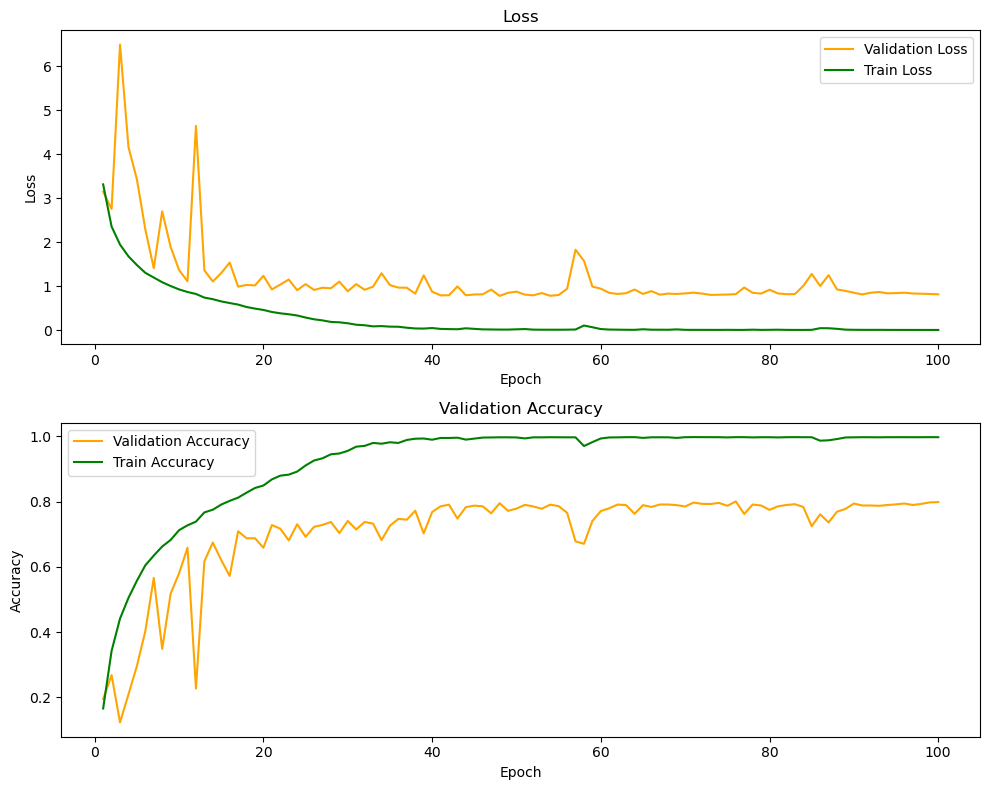

In [18]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

In [30]:
val_loss_array2, val_acc_array2, train_loss_array2, train_acc_array2 = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = "resnet_SGD_momentum=0.75_lr=0.026_2-2-2-blocks", last_epoch = 100)

Epoch [101/120], Train Loss: 0.0095, Train Accuracy: 99.75%
Epoch [101/120], Val Loss: 0.8433, Val Accuracy: 80.15%
weights saved
Epoch [102/120], Train Loss: 0.0094, Train Accuracy: 99.75%
Epoch [102/120], Val Loss: 0.8297, Val Accuracy: 80.10%
Epoch [103/120], Train Loss: 0.0093, Train Accuracy: 99.75%
Epoch [103/120], Val Loss: 0.8440, Val Accuracy: 79.50%
Epoch [104/120], Train Loss: 0.0100, Train Accuracy: 99.73%
Epoch [104/120], Val Loss: 0.8341, Val Accuracy: 79.90%
Epoch [105/120], Train Loss: 0.0093, Train Accuracy: 99.74%
Epoch [105/120], Val Loss: 0.8265, Val Accuracy: 80.10%
Epoch [106/120], Train Loss: 0.0093, Train Accuracy: 99.75%
Epoch [106/120], Val Loss: 0.8206, Val Accuracy: 79.85%
Epoch [107/120], Train Loss: 0.0094, Train Accuracy: 99.75%
Epoch [107/120], Val Loss: 0.8302, Val Accuracy: 79.75%
Epoch [108/120], Train Loss: 0.0092, Train Accuracy: 99.74%
Epoch [108/120], Val Loss: 0.8379, Val Accuracy: 79.90%
Epoch [109/120], Train Loss: 0.0092, Train Accuracy: 99.72

In [31]:
val_loss_array3, val_acc_array3, train_loss_array3, train_acc_array3 = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = "resnet_SGD_momentum=0.75_lr=0.026_2-2-2-blocks", last_epoch = 120)

Epoch [121/140], Train Loss: 0.0090, Train Accuracy: 99.74%
Epoch [121/140], Val Loss: 0.8521, Val Accuracy: 78.75%
Epoch [122/140], Train Loss: 0.0090, Train Accuracy: 99.75%
Epoch [122/140], Val Loss: 0.8376, Val Accuracy: 79.55%
Epoch [123/140], Train Loss: 0.0098, Train Accuracy: 99.73%
Epoch [123/140], Val Loss: 0.9361, Val Accuracy: 77.55%
Epoch [124/140], Train Loss: 0.0216, Train Accuracy: 99.39%
Epoch [124/140], Val Loss: 0.9181, Val Accuracy: 78.65%
Epoch [125/140], Train Loss: 0.0109, Train Accuracy: 99.75%
Epoch [125/140], Val Loss: 0.8600, Val Accuracy: 79.05%
Epoch [126/140], Train Loss: 0.0095, Train Accuracy: 99.74%
Epoch [126/140], Val Loss: 0.8486, Val Accuracy: 78.85%
Epoch [127/140], Train Loss: 0.0092, Train Accuracy: 99.74%
Epoch [127/140], Val Loss: 0.8552, Val Accuracy: 79.35%
Epoch [128/140], Train Loss: 0.0092, Train Accuracy: 99.74%
Epoch [128/140], Val Loss: 0.8538, Val Accuracy: 79.25%
Epoch [129/140], Train Loss: 0.0090, Train Accuracy: 99.73%
Epoch [129/1

In [35]:
val_loss_array4 = val_loss_array + val_loss_array2 + val_loss_array3
val_acc_array4 = val_acc_array + val_acc_array2 + val_acc_array3
train_loss_array4 = train_loss_array + train_loss_array2 + train_loss_array3
train_acc_array4 = train_acc_array + train_acc_array2 + train_acc_array3

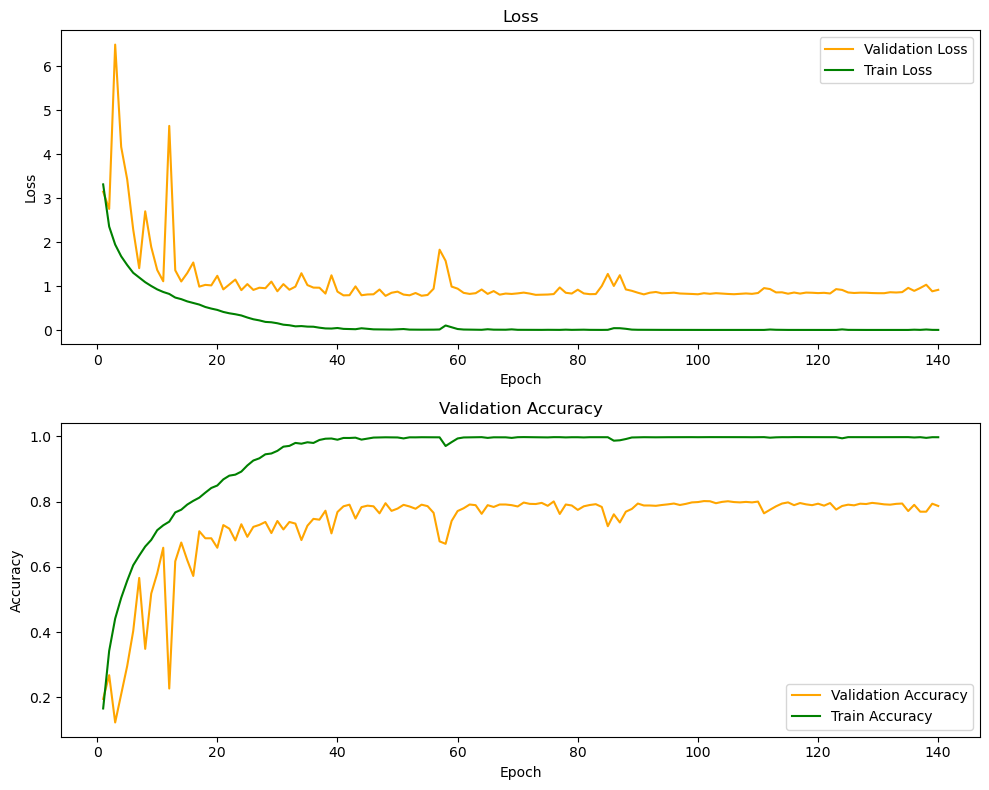

In [36]:
plot_loss_acc(val_loss_array4, val_acc_array4, train_loss_array4, train_acc_array4)

### architecture 1, lr =  0.054, momentum = 0.38, Resnet(2,2,2)

In [121]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.054, momentum = 0.38)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_momentum=0.39_lr=0.0594_2-2-2-blocks")

Epoch [1/80], Train Loss: 3.3347, Train Accuracy: 16.35%
Epoch [1/80], Val Loss: 3.0961, Val Accuracy: 19.50%
Epoch [2/80], Train Loss: 2.4360, Train Accuracy: 31.66%
Epoch [2/80], Val Loss: 3.5762, Val Accuracy: 19.96%
Epoch [3/80], Train Loss: 2.0556, Train Accuracy: 40.59%
Epoch [3/80], Val Loss: 1.9976, Val Accuracy: 41.08%
Epoch [4/80], Train Loss: 1.7942, Train Accuracy: 47.72%
Epoch [4/80], Val Loss: 2.1303, Val Accuracy: 40.23%
Epoch [5/80], Train Loss: 1.5980, Train Accuracy: 52.25%
Epoch [5/80], Val Loss: 3.8116, Val Accuracy: 26.69%
Epoch [6/80], Train Loss: 1.4443, Train Accuracy: 56.82%
Epoch [6/80], Val Loss: 1.8854, Val Accuracy: 48.27%
Epoch [7/80], Train Loss: 1.3169, Train Accuracy: 60.32%
Epoch [7/80], Val Loss: 1.5380, Val Accuracy: 55.58%
Epoch [8/80], Train Loss: 1.1951, Train Accuracy: 63.44%
Epoch [8/80], Val Loss: 1.4317, Val Accuracy: 56.88%
Epoch [9/80], Train Loss: 1.1065, Train Accuracy: 65.69%
Epoch [9/80], Val Loss: 1.7641, Val Accuracy: 53.23%
Epoch [10/

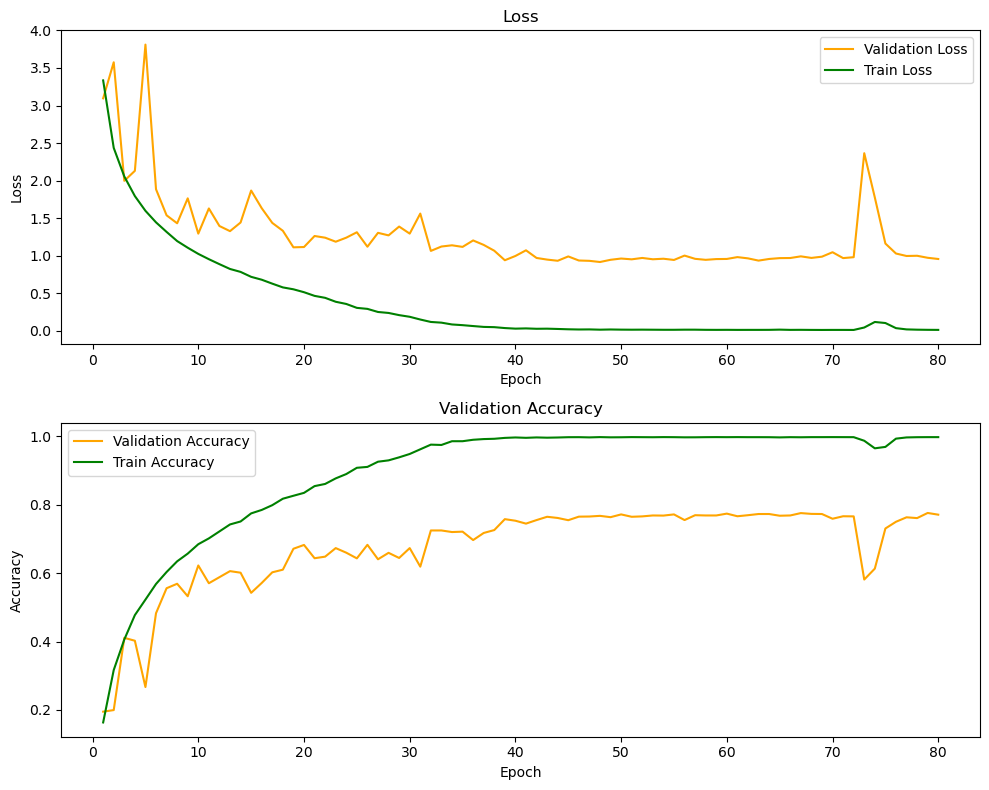

In [122]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

In [123]:
val_loss_array2, val_acc_array2, train_loss_array2, train_acc_array2 = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 20, save_weights = True, weights_path = "resnet_SGD_momentum=0.39_lr=0.0594_2-2-2-blocks", last_epoch = 80)

Epoch [81/100], Train Loss: 0.0115, Train Accuracy: 99.75%
Epoch [81/100], Val Loss: 0.9765, Val Accuracy: 76.69%
Epoch [82/100], Train Loss: 0.0111, Train Accuracy: 99.74%
Epoch [82/100], Val Loss: 0.9813, Val Accuracy: 77.12%
Epoch [83/100], Train Loss: 0.0110, Train Accuracy: 99.74%
Epoch [83/100], Val Loss: 0.9767, Val Accuracy: 77.19%
Epoch [84/100], Train Loss: 0.0105, Train Accuracy: 99.74%
Epoch [84/100], Val Loss: 0.9651, Val Accuracy: 77.27%
Epoch [85/100], Train Loss: 0.0101, Train Accuracy: 99.74%
Epoch [85/100], Val Loss: 0.9679, Val Accuracy: 77.23%
Epoch [86/100], Train Loss: 0.0106, Train Accuracy: 99.75%
Epoch [86/100], Val Loss: 0.9700, Val Accuracy: 77.08%
Epoch [87/100], Train Loss: 0.0100, Train Accuracy: 99.75%
Epoch [87/100], Val Loss: 0.9783, Val Accuracy: 77.15%
Epoch [88/100], Train Loss: 0.0100, Train Accuracy: 99.75%
Epoch [88/100], Val Loss: 0.9809, Val Accuracy: 77.15%
Epoch [89/100], Train Loss: 0.0101, Train Accuracy: 99.74%
Epoch [89/100], Val Loss: 0.9

In [124]:
val_loss_array3 = val_loss_array + val_loss_array2
val_acc_array3 = val_acc_array + val_acc_array2
train_loss_array3 = train_loss_array + train_loss_array2
train_acc_array3 = train_acc_array + train_acc_array2

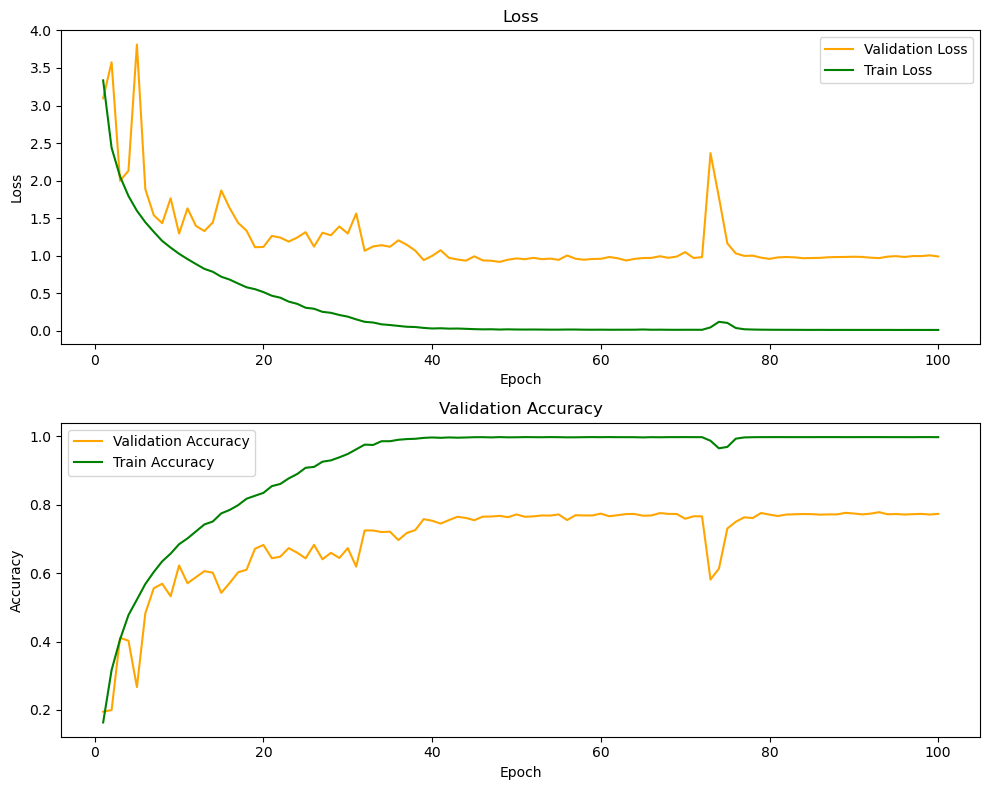

In [125]:
plot_loss_acc(val_loss_array3, val_acc_array3, train_loss_array3, train_acc_array3)

### architecture 1, lr =  0.054, momentum = 0.9, Resnet(2,2,2)

In [163]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.054, momentum = 0.9)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 100, save_weights = True, weights_path = "resnet_SGD_momentum=0.9_lr=0.0594_2-2-2-blocks")

Epoch [1/100], Train Loss: 3.7211, Train Accuracy: 10.03%
Epoch [1/100], Val Loss: 3.3809, Val Accuracy: 16.12%
Epoch [2/100], Train Loss: 2.8230, Train Accuracy: 24.89%
Epoch [2/100], Val Loss: 3.1914, Val Accuracy: 18.54%
Epoch [3/100], Train Loss: 2.3010, Train Accuracy: 35.29%
Epoch [3/100], Val Loss: 2.0415, Val Accuracy: 40.88%
Epoch [4/100], Train Loss: 1.9889, Train Accuracy: 42.18%
Epoch [4/100], Val Loss: 2.5498, Val Accuracy: 36.54%
Epoch [5/100], Train Loss: 1.7295, Train Accuracy: 49.25%
Epoch [5/100], Val Loss: 1.9453, Val Accuracy: 45.54%
Epoch [6/100], Train Loss: 1.5376, Train Accuracy: 54.43%
Epoch [6/100], Val Loss: 1.7799, Val Accuracy: 49.15%
Epoch [7/100], Train Loss: 1.3957, Train Accuracy: 57.93%
Epoch [7/100], Val Loss: 1.6223, Val Accuracy: 51.58%
Epoch [8/100], Train Loss: 1.2485, Train Accuracy: 61.96%
Epoch [8/100], Val Loss: 1.4855, Val Accuracy: 56.31%
Epoch [9/100], Train Loss: 1.1359, Train Accuracy: 65.12%
Epoch [9/100], Val Loss: 1.5101, Val Accuracy:

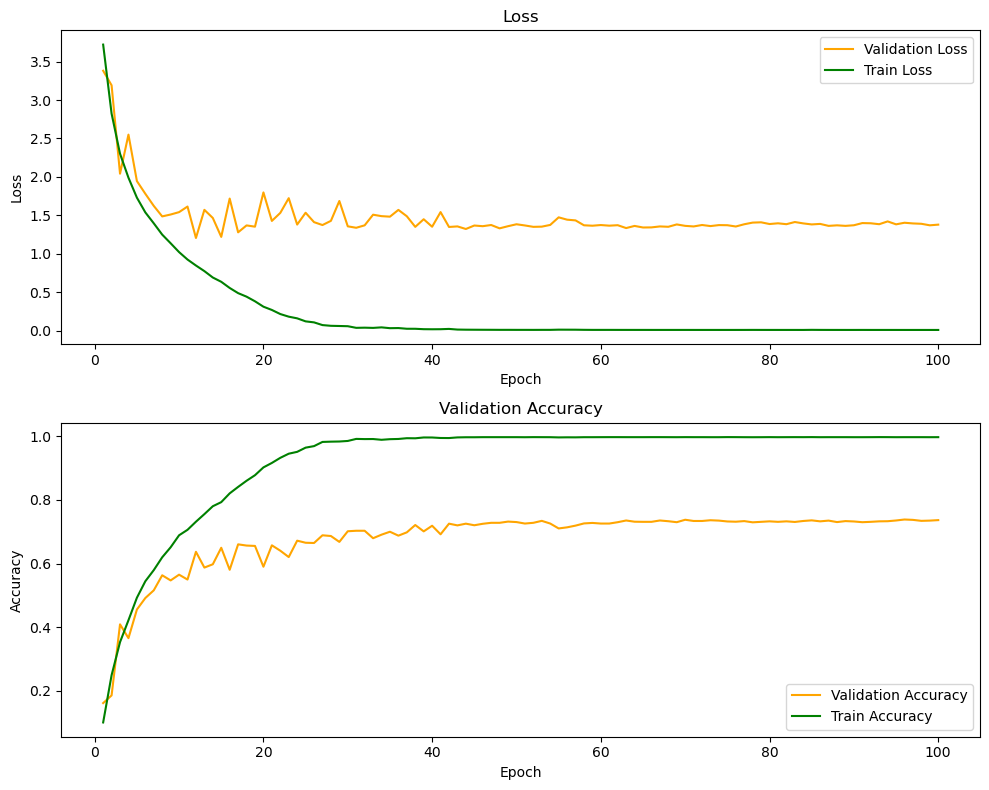

In [164]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0.9, Resnet(3,3,3)

In [113]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [3, 3, 3])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_momentum=0.9_lr=0.01_3-3-3-blocks")

Epoch [1/80], Train Loss: 3.6145, Train Accuracy: 12.80%
Epoch [1/80], Val Loss: 3.5822, Val Accuracy: 13.92%
Epoch [2/80], Train Loss: 2.7454, Train Accuracy: 26.09%
Epoch [2/80], Val Loss: 3.0118, Val Accuracy: 24.54%
Epoch [3/80], Train Loss: 2.2490, Train Accuracy: 36.20%
Epoch [3/80], Val Loss: 2.6574, Val Accuracy: 31.69%
Epoch [4/80], Train Loss: 1.9663, Train Accuracy: 43.69%
Epoch [4/80], Val Loss: 2.3903, Val Accuracy: 38.19%
Epoch [5/80], Train Loss: 1.7247, Train Accuracy: 49.55%
Epoch [5/80], Val Loss: 2.0797, Val Accuracy: 43.38%
Epoch [6/80], Train Loss: 1.5152, Train Accuracy: 54.76%
Epoch [6/80], Val Loss: 2.4710, Val Accuracy: 34.31%
Epoch [7/80], Train Loss: 1.3805, Train Accuracy: 58.51%
Epoch [7/80], Val Loss: 1.6158, Val Accuracy: 54.42%
Epoch [8/80], Train Loss: 1.2669, Train Accuracy: 61.35%
Epoch [8/80], Val Loss: 1.5495, Val Accuracy: 55.08%
Epoch [9/80], Train Loss: 1.1433, Train Accuracy: 65.07%
Epoch [9/80], Val Loss: 1.4631, Val Accuracy: 56.92%
Epoch [10/

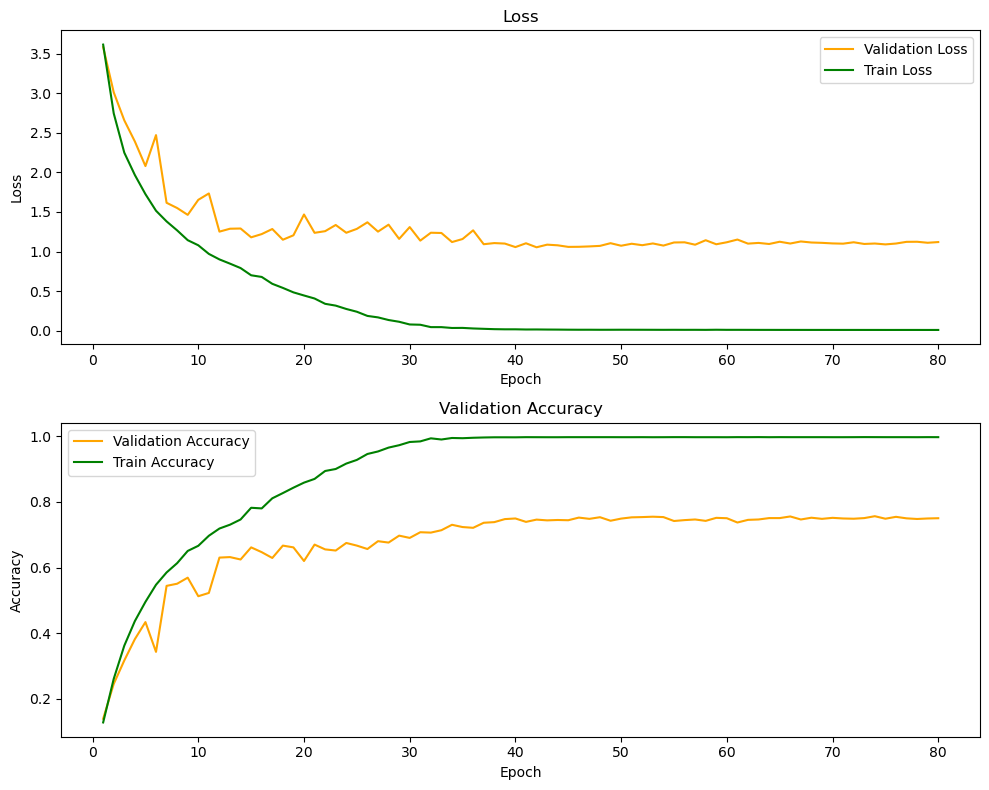

In [115]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0.95, Resnet(3,3,3)

In [111]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [3, 3, 3])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.95)
max_accuracy = 0.76
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_momentum=0.95_lr=0.01_3-3-3-blocks")

Epoch [1/80], Train Loss: 3.6778, Train Accuracy: 11.53%
Epoch [1/80], Val Loss: 3.4718, Val Accuracy: 13.04%
Epoch [2/80], Train Loss: 2.7385, Train Accuracy: 25.26%
Epoch [2/80], Val Loss: 2.7431, Val Accuracy: 26.31%
Epoch [3/80], Train Loss: 2.3544, Train Accuracy: 34.08%
Epoch [3/80], Val Loss: 2.4548, Val Accuracy: 35.42%
Epoch [4/80], Train Loss: 2.0581, Train Accuracy: 40.61%
Epoch [4/80], Val Loss: 2.1752, Val Accuracy: 38.00%
Epoch [5/80], Train Loss: 1.8343, Train Accuracy: 46.66%
Epoch [5/80], Val Loss: 1.7844, Val Accuracy: 49.62%
Epoch [6/80], Train Loss: 1.6021, Train Accuracy: 52.63%
Epoch [6/80], Val Loss: 1.7445, Val Accuracy: 49.77%
Epoch [7/80], Train Loss: 1.4623, Train Accuracy: 56.23%
Epoch [7/80], Val Loss: 1.6755, Val Accuracy: 52.96%
Epoch [8/80], Train Loss: 1.3313, Train Accuracy: 59.94%
Epoch [8/80], Val Loss: 1.7176, Val Accuracy: 51.62%
Epoch [9/80], Train Loss: 1.2154, Train Accuracy: 63.04%
Epoch [9/80], Val Loss: 1.4348, Val Accuracy: 57.12%
Epoch [10/

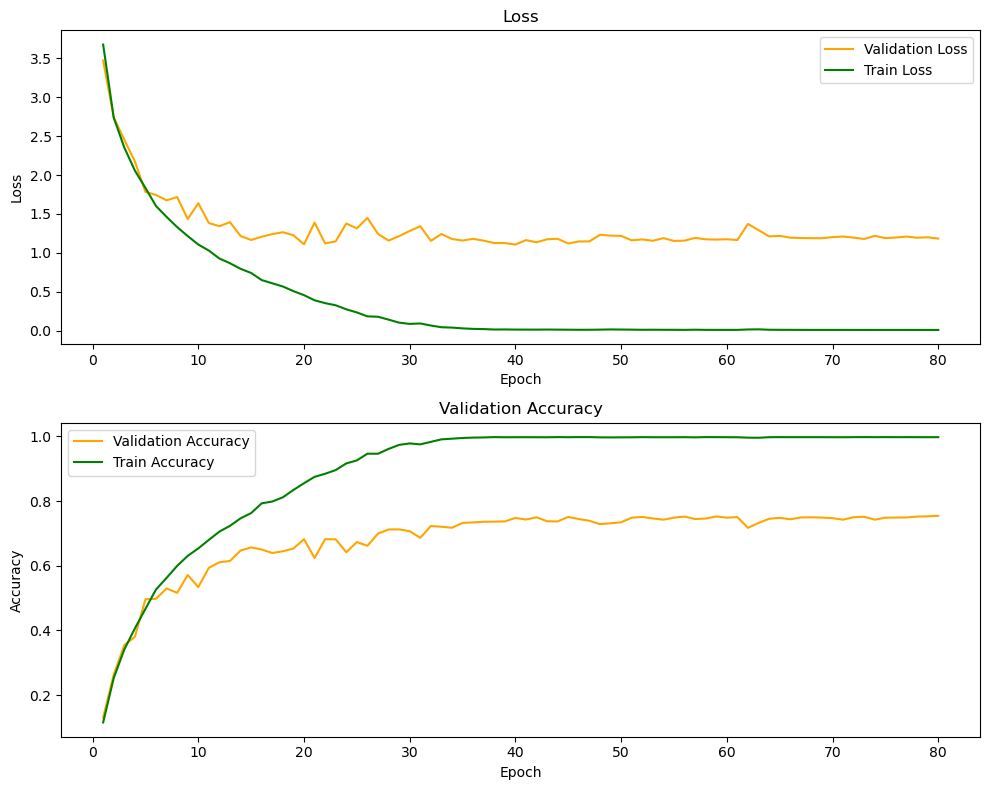

In [112]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0.5, Resnet(3,2,2)

In [109]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [3, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.5)
max_accuracy = 0.78
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_momentum=0.5_lr=0.01_3-2-2-blocks")

Epoch [1/80], Train Loss: 3.6315, Train Accuracy: 12.96%
Epoch [1/80], Val Loss: 3.3581, Val Accuracy: 14.85%
Epoch [2/80], Train Loss: 2.7374, Train Accuracy: 27.48%
Epoch [2/80], Val Loss: 2.5820, Val Accuracy: 29.04%
Epoch [3/80], Train Loss: 2.3000, Train Accuracy: 37.12%
Epoch [3/80], Val Loss: 2.3183, Val Accuracy: 35.19%
Epoch [4/80], Train Loss: 1.9990, Train Accuracy: 44.67%
Epoch [4/80], Val Loss: 2.1851, Val Accuracy: 39.31%
Epoch [5/80], Train Loss: 1.8037, Train Accuracy: 48.71%
Epoch [5/80], Val Loss: 1.7869, Val Accuracy: 48.08%
Epoch [6/80], Train Loss: 1.6367, Train Accuracy: 52.99%
Epoch [6/80], Val Loss: 1.9453, Val Accuracy: 44.35%
Epoch [7/80], Train Loss: 1.4944, Train Accuracy: 57.09%
Epoch [7/80], Val Loss: 1.7121, Val Accuracy: 49.92%
Epoch [8/80], Train Loss: 1.3634, Train Accuracy: 60.59%
Epoch [8/80], Val Loss: 3.8502, Val Accuracy: 20.00%
Epoch [9/80], Train Loss: 1.3014, Train Accuracy: 61.71%
Epoch [9/80], Val Loss: 2.4351, Val Accuracy: 33.23%
Epoch [10/

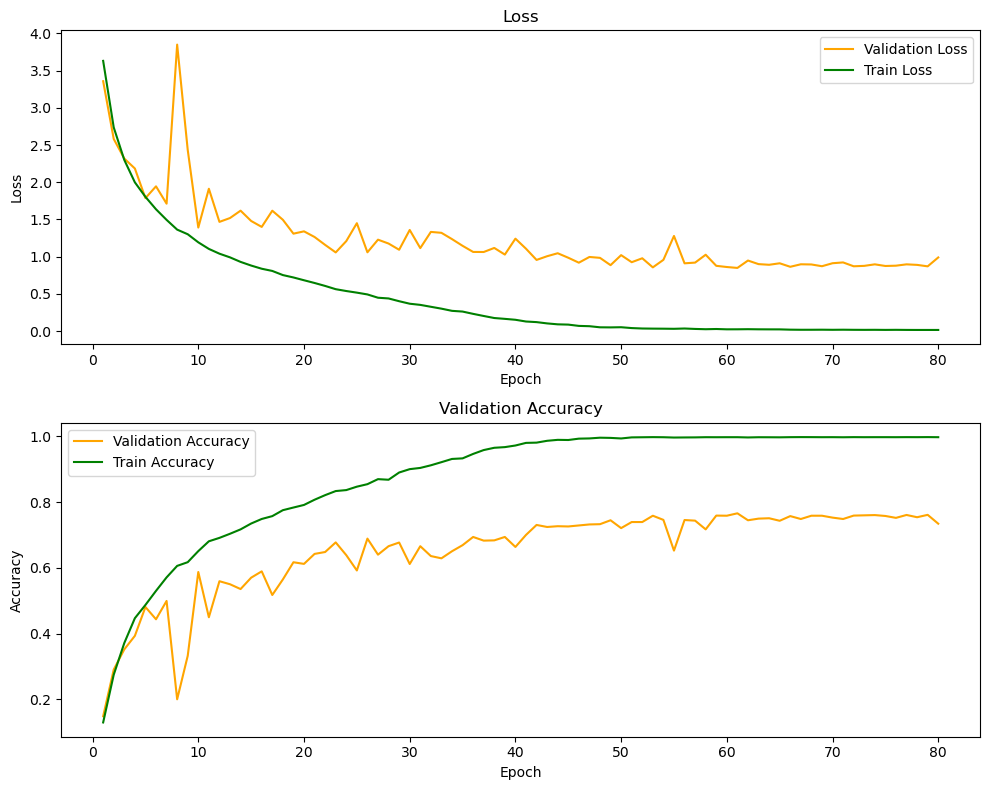

In [110]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0.9 - PREDICTION 2_SGD

In [73]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [2, 2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
max_accuracy = 0.78
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 100, save_weights = True, weights_path = "resnet_SGD_momentum=09_lr=0.01")

Epoch [1/100], Train Loss: 3.3961, Train Accuracy: 15.59%
Epoch [1/100], Val Loss: 3.2834, Val Accuracy: 15.96%
Epoch [2/100], Train Loss: 2.5408, Train Accuracy: 30.30%
Epoch [2/100], Val Loss: 3.4071, Val Accuracy: 22.04%
Epoch [3/100], Train Loss: 2.1143, Train Accuracy: 40.18%
Epoch [3/100], Val Loss: 2.3114, Val Accuracy: 38.23%
Epoch [4/100], Train Loss: 1.8388, Train Accuracy: 46.76%
Epoch [4/100], Val Loss: 1.8672, Val Accuracy: 46.38%
Epoch [5/100], Train Loss: 1.6333, Train Accuracy: 52.12%
Epoch [5/100], Val Loss: 1.9547, Val Accuracy: 43.54%
Epoch [6/100], Train Loss: 1.4765, Train Accuracy: 55.39%
Epoch [6/100], Val Loss: 1.7894, Val Accuracy: 48.85%
Epoch [7/100], Train Loss: 1.3537, Train Accuracy: 59.18%
Epoch [7/100], Val Loss: 1.6693, Val Accuracy: 50.96%
Epoch [8/100], Train Loss: 1.2267, Train Accuracy: 63.01%
Epoch [8/100], Val Loss: 1.8349, Val Accuracy: 50.73%
Epoch [9/100], Train Loss: 1.1371, Train Accuracy: 65.20%
Epoch [9/100], Val Loss: 1.9893, Val Accuracy:

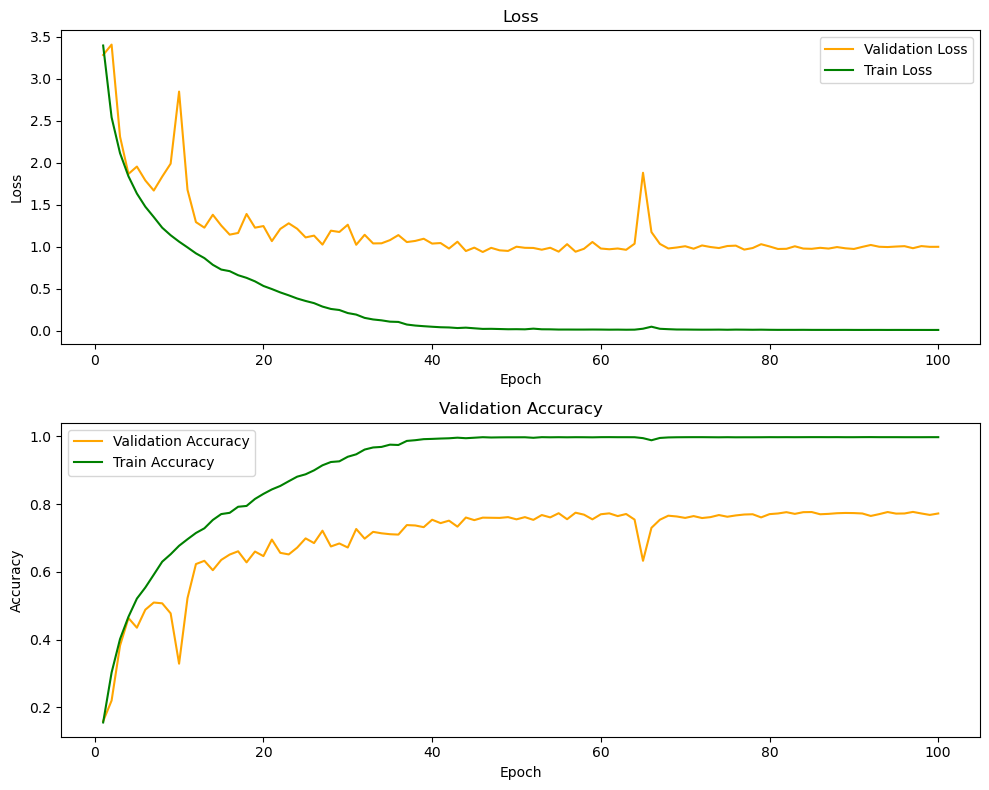

In [75]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0.9, batch_size=128

In [93]:
# arhitectura prediction 2
model2 = ResNet(BasicBlock, [2, 2, 2, 2])
model2 = model2.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum = 0.9)
max_accuracy = 0.78
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model2, optimizer, X_train, y_train, X_test, y_test, batch_size = 128, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_momentum=0.9_lr=0.01_batch=128")

Epoch [1/80], Train Loss: 3.7016, Train Accuracy: 12.32%
Epoch [1/80], Val Loss: 3.3980, Val Accuracy: 12.58%
Epoch [2/80], Train Loss: 2.6900, Train Accuracy: 28.13%
Epoch [2/80], Val Loss: 2.8147, Val Accuracy: 26.23%
Epoch [3/80], Train Loss: 2.2107, Train Accuracy: 38.86%
Epoch [3/80], Val Loss: 3.8399, Val Accuracy: 18.96%
Epoch [4/80], Train Loss: 1.9186, Train Accuracy: 46.05%
Epoch [4/80], Val Loss: 3.9285, Val Accuracy: 17.88%
Epoch [5/80], Train Loss: 1.6865, Train Accuracy: 52.44%
Epoch [5/80], Val Loss: 3.7622, Val Accuracy: 18.00%
Epoch [6/80], Train Loss: 1.5340, Train Accuracy: 55.87%
Epoch [6/80], Val Loss: 3.0713, Val Accuracy: 26.92%
Epoch [7/80], Train Loss: 1.4224, Train Accuracy: 58.82%
Epoch [7/80], Val Loss: 3.7543, Val Accuracy: 21.65%
Epoch [8/80], Train Loss: 1.2949, Train Accuracy: 62.04%
Epoch [8/80], Val Loss: 2.1455, Val Accuracy: 36.65%
Epoch [9/80], Train Loss: 1.2116, Train Accuracy: 64.22%
Epoch [9/80], Val Loss: 1.7294, Val Accuracy: 49.88%
Epoch [10/

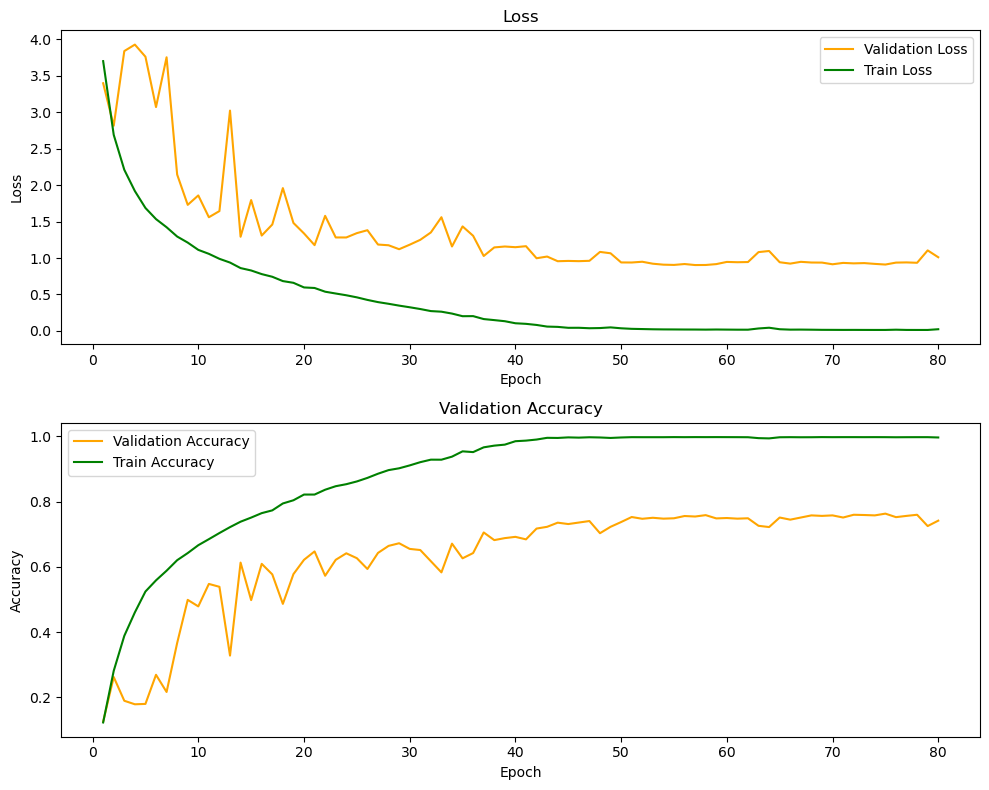

In [94]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.01, momentum = 0 (default)

In [62]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [2, 2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01)
max_accuracy = 0.77
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_no_momentum")

Epoch [1/80], Train Loss: 3.8588, Train Accuracy: 10.80%
Epoch [1/80], Val Loss: 3.2919, Val Accuracy: 16.88%
Epoch [2/80], Train Loss: 3.0885, Train Accuracy: 22.35%
Epoch [2/80], Val Loss: 3.2516, Val Accuracy: 17.46%
Epoch [3/80], Train Loss: 2.6809, Train Accuracy: 30.08%
Epoch [3/80], Val Loss: 2.8303, Val Accuracy: 25.19%
Epoch [4/80], Train Loss: 2.3842, Train Accuracy: 37.29%
Epoch [4/80], Val Loss: 2.2698, Val Accuracy: 37.85%
Epoch [5/80], Train Loss: 2.1543, Train Accuracy: 41.80%
Epoch [5/80], Val Loss: 2.3992, Val Accuracy: 34.92%
Epoch [6/80], Train Loss: 1.9728, Train Accuracy: 46.47%
Epoch [6/80], Val Loss: 2.1170, Val Accuracy: 39.73%
Epoch [7/80], Train Loss: 1.8346, Train Accuracy: 49.67%
Epoch [7/80], Val Loss: 2.1746, Val Accuracy: 39.58%
Epoch [8/80], Train Loss: 1.7143, Train Accuracy: 52.36%
Epoch [8/80], Val Loss: 2.6814, Val Accuracy: 34.96%
Epoch [9/80], Train Loss: 1.6027, Train Accuracy: 55.40%
Epoch [9/80], Val Loss: 2.2225, Val Accuracy: 38.69%
Epoch [10/

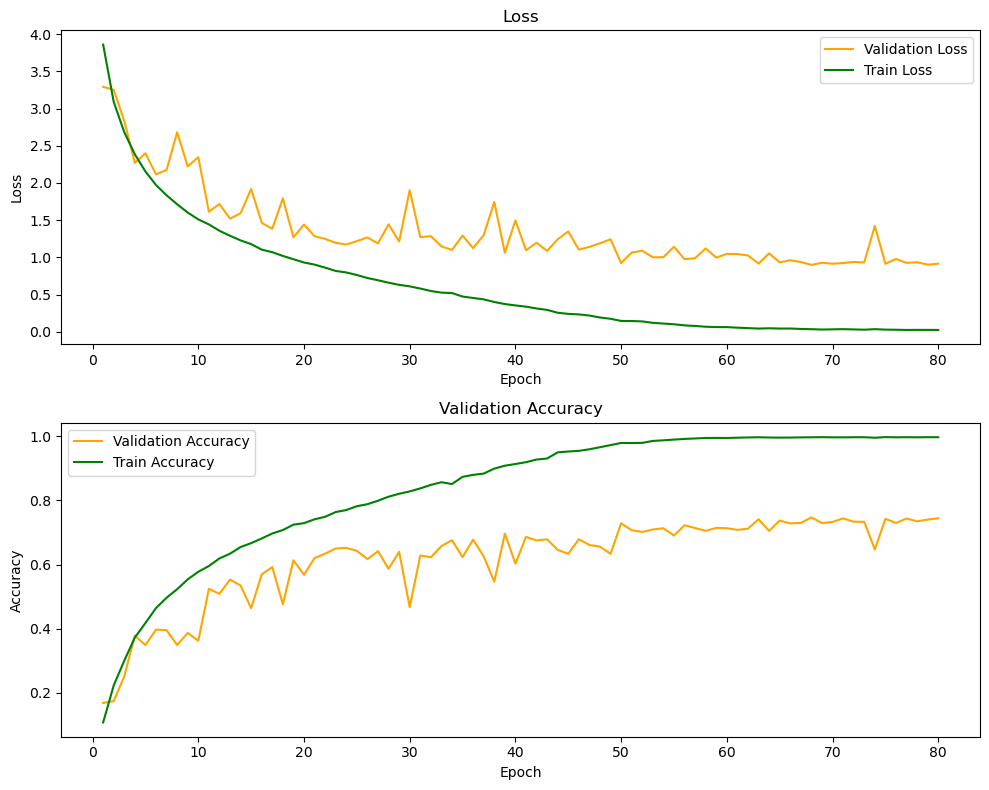

In [63]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

### architecture 1, lr =  0.001, momentum = 0

In [64]:
# arhitectura prediction 2
model = ResNet(BasicBlock, [2, 2, 2, 2])
model = model.to('cuda')
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001)
max_accuracy = 0.77
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_SGD_no_momentum")

Epoch [1/80], Train Loss: 4.5693, Train Accuracy: 2.02%
Epoch [1/80], Val Loss: 4.4059, Val Accuracy: 5.88%
Epoch [2/80], Train Loss: 4.2582, Train Accuracy: 7.47%
Epoch [2/80], Val Loss: 4.0551, Val Accuracy: 10.81%
Epoch [3/80], Train Loss: 3.9820, Train Accuracy: 11.26%
Epoch [3/80], Val Loss: 3.8148, Val Accuracy: 12.46%
Epoch [4/80], Train Loss: 3.7988, Train Accuracy: 12.55%
Epoch [4/80], Val Loss: 3.6449, Val Accuracy: 14.73%
Epoch [5/80], Train Loss: 3.6609, Train Accuracy: 15.48%
Epoch [5/80], Val Loss: 3.5284, Val Accuracy: 17.12%
Epoch [6/80], Train Loss: 3.5451, Train Accuracy: 17.42%
Epoch [6/80], Val Loss: 3.4233, Val Accuracy: 19.46%
Epoch [7/80], Train Loss: 3.4486, Train Accuracy: 19.67%
Epoch [7/80], Val Loss: 3.3343, Val Accuracy: 21.62%
Epoch [8/80], Train Loss: 3.3464, Train Accuracy: 21.94%
Epoch [8/80], Val Loss: 3.2188, Val Accuracy: 24.35%
Epoch [9/80], Train Loss: 3.2514, Train Accuracy: 23.62%
Epoch [9/80], Val Loss: 3.1089, Val Accuracy: 25.88%
Epoch [10/80]

In [67]:
torch.save(model.state_dict(), f'weights/resnet_SGD_momentum=0_lr=0.001_epoch80.pth')

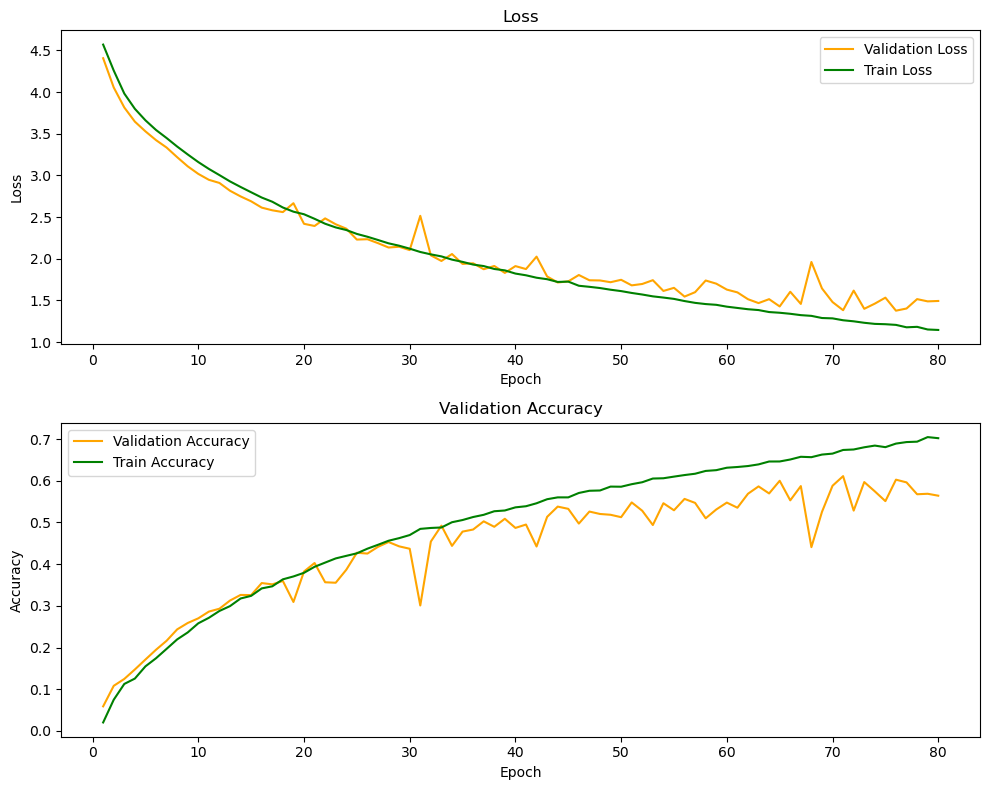

In [66]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

In [69]:
val_loss_array2, val_acc_array2, train_loss_array2, train_acc_array2 = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 220, save_weights = True, weights_path = "resnet_SGD_momentum=0_lr=0.001", last_epoch = 80)

Epoch [81/300], Train Loss: 1.1356, Train Accuracy: 70.80%
Epoch [81/300], Val Loss: 1.4772, Val Accuracy: 57.65%
Epoch [82/300], Train Loss: 1.1242, Train Accuracy: 70.84%
Epoch [82/300], Val Loss: 1.2885, Val Accuracy: 63.23%
Epoch [83/300], Train Loss: 1.1125, Train Accuracy: 71.02%
Epoch [83/300], Val Loss: 1.4003, Val Accuracy: 58.88%
Epoch [84/300], Train Loss: 1.0939, Train Accuracy: 71.96%
Epoch [84/300], Val Loss: 1.2709, Val Accuracy: 63.31%
Epoch [85/300], Train Loss: 1.0892, Train Accuracy: 71.62%
Epoch [85/300], Val Loss: 1.3533, Val Accuracy: 59.50%
Epoch [86/300], Train Loss: 1.0807, Train Accuracy: 72.32%
Epoch [86/300], Val Loss: 1.3010, Val Accuracy: 62.77%
Epoch [87/300], Train Loss: 1.0708, Train Accuracy: 72.38%
Epoch [87/300], Val Loss: 1.2550, Val Accuracy: 64.00%
Epoch [88/300], Train Loss: 1.0544, Train Accuracy: 72.62%
Epoch [88/300], Val Loss: 1.3045, Val Accuracy: 62.62%
Epoch [89/300], Train Loss: 1.0386, Train Accuracy: 73.05%
Epoch [89/300], Val Loss: 1.3

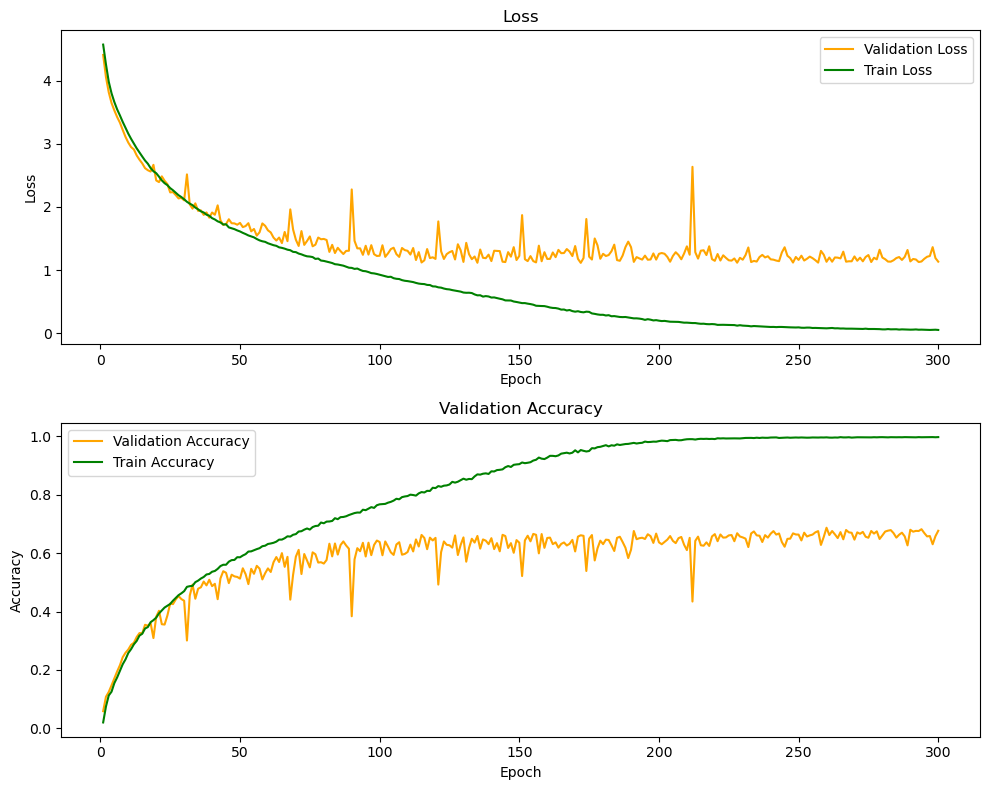

In [91]:
plot_loss_acc(val_loss_array5, val_acc_array5, train_loss_array5, train_acc_array5)

In [72]:
torch.save(model.state_dict(), f'weights/resnet_SGD_momentum=0_lr=0.001_epoch300.pth')

### din train pt prediction2 sgd, de rulat iar pt 80 epoci din prima

In [26]:
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 15, save_weights = True, weights_path = "resnet_SGD", last_epoch = 30)

Epoch [31/15], Train Loss: 0.1740, Train Accuracy: 95.24%
Epoch [31/15], Val Loss: 1.1754, Val Accuracy: 69.00%
Epoch [32/15], Train Loss: 0.1489, Train Accuracy: 96.13%
Epoch [32/15], Val Loss: 1.1014, Val Accuracy: 70.77%
weights saved
Epoch [33/15], Train Loss: 0.1468, Train Accuracy: 96.15%
Epoch [33/15], Val Loss: 1.4142, Val Accuracy: 65.42%
Epoch [34/15], Train Loss: 0.1240, Train Accuracy: 96.93%
Epoch [34/15], Val Loss: 1.1264, Val Accuracy: 70.12%
weights saved
Epoch [35/15], Train Loss: 0.0845, Train Accuracy: 98.35%
Epoch [35/15], Val Loss: 0.9609, Val Accuracy: 75.42%
weights saved
Epoch [36/15], Train Loss: 0.0871, Train Accuracy: 98.11%
Epoch [36/15], Val Loss: 1.0994, Val Accuracy: 71.46%
weights saved
Epoch [37/15], Train Loss: 0.0856, Train Accuracy: 98.32%
Epoch [37/15], Val Loss: 1.1208, Val Accuracy: 71.65%
weights saved
Epoch [38/15], Train Loss: 0.0750, Train Accuracy: 98.41%
Epoch [38/15], Val Loss: 1.1059, Val Accuracy: 72.19%
weights saved
Epoch [39/15], Train

In [38]:
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 15, save_weights = True, weights_path = "resnet_SGD", last_epoch = 45)

Epoch [46/15], Train Loss: 0.0205, Train Accuracy: 99.66%
Epoch [46/15], Val Loss: 1.0044, Val Accuracy: 75.04%
weights saved
Epoch [47/15], Train Loss: 0.0233, Train Accuracy: 99.62%
Epoch [47/15], Val Loss: 1.1613, Val Accuracy: 71.62%
weights saved
Epoch [48/15], Train Loss: 0.0224, Train Accuracy: 99.69%
Epoch [48/15], Val Loss: 0.9401, Val Accuracy: 76.92%
weights saved
Epoch [49/15], Train Loss: 0.0193, Train Accuracy: 99.66%
Epoch [49/15], Val Loss: 0.9502, Val Accuracy: 76.62%
weights saved
Epoch [50/15], Train Loss: 0.0162, Train Accuracy: 99.72%
Epoch [50/15], Val Loss: 0.9318, Val Accuracy: 76.81%
weights saved
Epoch [51/15], Train Loss: 0.0156, Train Accuracy: 99.73%
Epoch [51/15], Val Loss: 0.9355, Val Accuracy: 77.27%
weights saved
Epoch [52/15], Train Loss: 0.0151, Train Accuracy: 99.76%
Epoch [52/15], Val Loss: 0.9450, Val Accuracy: 77.04%
weights saved
Epoch [53/15], Train Loss: 0.0135, Train Accuracy: 99.75%
Epoch [53/15], Val Loss: 0.9419, Val Accuracy: 77.54%
weight

In [49]:
acc_max = 0.78
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 15, save_weights = True, weights_path = "resnet_SGD", last_epoch = 61)

Epoch [62/15], Train Loss: 0.0101, Train Accuracy: 99.74%
Epoch [62/15], Val Loss: 0.9738, Val Accuracy: 77.92%
Epoch [63/15], Train Loss: 0.0099, Train Accuracy: 99.73%
Epoch [63/15], Val Loss: 0.9886, Val Accuracy: 77.50%
Epoch [64/15], Train Loss: 0.0100, Train Accuracy: 99.76%
Epoch [64/15], Val Loss: 0.9810, Val Accuracy: 77.54%
Epoch [65/15], Train Loss: 0.0101, Train Accuracy: 99.74%
Epoch [65/15], Val Loss: 0.9690, Val Accuracy: 78.15%
weights saved
Epoch [66/15], Train Loss: 0.0180, Train Accuracy: 99.57%
Epoch [66/15], Val Loss: 1.2326, Val Accuracy: 72.62%
Epoch [67/15], Train Loss: 0.0202, Train Accuracy: 99.58%
Epoch [67/15], Val Loss: 1.0743, Val Accuracy: 75.65%
Epoch [68/15], Train Loss: 0.0156, Train Accuracy: 99.67%
Epoch [68/15], Val Loss: 1.0177, Val Accuracy: 76.77%
Epoch [69/15], Train Loss: 0.0112, Train Accuracy: 99.75%
Epoch [69/15], Val Loss: 1.0078, Val Accuracy: 76.77%
Epoch [70/15], Train Loss: 0.0119, Train Accuracy: 99.71%
Epoch [70/15], Val Loss: 1.0672,

## Resnet with different extansions

In [11]:
# Define the basic block for ResNet
class Block_with_extansion(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, extansion = 1):
        super(Block_with_extansion, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.extansion = extansion

        # Shortcut connection to match dimensions
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_channels != self.extansion * out_channels:
        #     print("reached downsample", in_channels, self.extansion * out_channels)
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, self.extansion * out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.extansion * out_channels)
            # )
        self.downsample = None
        # if is_first_block and stride != 1:
        if stride != 1 or in_channels != extansion * out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                      out_channels= out_channels,
                                                      kernel_size=1,
                                                      stride=stride,
                                                      padding=0),
                                            nn.BatchNorm2d(out_channels))

    def forward(self, x):
        residual = x.clone()
        # print("block initial shape:", x.shape)
        x = self.relu(self.bn1(self.conv1(x)))
        # print("block shape after conv1:", x.shape)
        x = self.bn2(self.conv2(x))
        # print("block shape after conv2:", x.shape)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        # print("block shape after residual:", x.shape)
        x = self.relu(x)
        return x


In [12]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 100, extansion = 1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], 3, 1, 1, extansion)
        self.layer2 = self.make_layer(block, 128, num_blocks[1]*extansion, 3, 2, 1, extansion)
        self.layer3 = self.make_layer(block, 256, num_blocks[2]*extansion, 3, 2, 1, extansion)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding, extansion):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding, extansion))
        self.in_channels = out_channels * extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding, extansion))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [13]:
model = ResNet(Block_with_extansion, [2, 2, 2], 1)
model = model.to("cuda")
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 1])


In [14]:
out

tensor([[0.6345]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
model = ResNet(Block, [2, 2, 2])
model = model.to('cuda')

optimizer = optim.SGD(model.parameters(), lr=0.026, momentum = 0.755)
max_accuracy = 0.77
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 80, save_weights = True, weights_path = "resnet_ext=2")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Resnet with bottleneck

In [22]:
# Define the basic block for ResNet
class Block_bottleneck(nn.Module):
    extansion = 2

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Block_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.extansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.extansion)

        # Shortcut connection to match dimensions
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_channels != self.extansion * out_channels:
        #     print("reached downsample", in_channels, self.extansion * out_channels)
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_channels, self.extansion * out_channels, kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(self.extansion * out_channels)
            # )
        self.downsample = None
        # if is_first_block and stride != 1:
        if stride != 1 or in_channels != self.extansion * out_channels:
            self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels, 
                                                      out_channels= out_channels * self.extansion,
                                                      kernel_size=1,
                                                      stride=stride,
                                                      padding=0),
                                            nn.BatchNorm2d(out_channels * self.extansion))

    def forward(self, x):
        residual = x.clone()
        # print("block initial shape:", x.shape)
        x = self.relu(self.bn1(self.conv1(x)))
        # print("block shape after conv1:", x.shape)
        x = self.relu(self.bn2(self.conv2(x)))
        # print("block shape after conv2:", x.shape)
        x = self.bn3(self.conv3(x))
        # print("block shape after conv3:", x.shape)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        # print("block shape after residual:", x.shape)
        x = self.relu(x)
        return x


In [31]:
# Define the ResNet model
class ResNet2(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet2, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], 3, 1, 1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1]*block.extansion, 3, 1, 1)
        self.layer3 = self.make_layer(block, 256, num_blocks[2]*block.extansion, 3, 2, 1)
        self.layer4 = self.make_layer(block, 512, num_blocks[3]*block.extansion, 3, 2, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.extansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, kernel_size, stride, padding):
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, padding))
        self.in_channels = out_channels * block.extansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, kernel_size, 1, padding))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        # print("resnet first layers shape:", x.shape)
        x = self.layer1(x)
        # print("layer1 shape:", x.shape)
        x = self.layer2(x)
        # print("layer2 shape:", x.shape)
        x = self.layer3(x)
        # print("layer3 shape:", x.shape)
        x = self.layer4(x)
        # print("layer4 shape:", x.shape)
        # Classification head
        y = self.avg_pool(x)
        y = y.reshape(y.shape[0], -1)
        # print("classification shape:", y.shape)
        y = self.fc(y)
        # print("classification shape:", y.shape)
        return y



In [32]:
model = ResNet2(Block, [2, 2, 2, 2])
model = model.to("cuda")
sample = X_train[0].unsqueeze(-1).permute(3, 0, 1, 2)
print(sample.shape)
out = model(sample)
# out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 100])


In [33]:
model = ResNet2(Block, [2, 2, 2, 2])
model = model.to("cuda")
optimizer = optim.SGD(model.parameters(), lr=0.026, momentum = 0.755)
max_accuracy = 0.77
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 50, save_weights = True, weights_path = "resnet_lr=0.026_mom=0.755")

Epoch [1/50], Train Loss: 3.4199, Train Accuracy: 14.75%
Epoch [1/50], Val Loss: 5.9382, Val Accuracy: 9.20%
Epoch [2/50], Train Loss: 2.4653, Train Accuracy: 31.49%
Epoch [2/50], Val Loss: 6.3287, Val Accuracy: 11.45%
Epoch [3/50], Train Loss: 2.0253, Train Accuracy: 41.45%
Epoch [3/50], Val Loss: 2.6213, Val Accuracy: 31.60%
Epoch [4/50], Train Loss: 1.7166, Train Accuracy: 49.49%
Epoch [4/50], Val Loss: 1.7116, Val Accuracy: 49.20%
Epoch [5/50], Train Loss: 1.4923, Train Accuracy: 55.84%
Epoch [5/50], Val Loss: 1.6147, Val Accuracy: 52.70%
Epoch [6/50], Train Loss: 1.3060, Train Accuracy: 60.24%
Epoch [6/50], Val Loss: 3.1902, Val Accuracy: 27.25%
Epoch [7/50], Train Loss: 1.1599, Train Accuracy: 64.35%
Epoch [7/50], Val Loss: 1.6712, Val Accuracy: 53.80%
Epoch [8/50], Train Loss: 1.0807, Train Accuracy: 67.12%
Epoch [8/50], Val Loss: 1.3477, Val Accuracy: 59.90%


KeyboardInterrupt: 

In [34]:
torch.save(model.state_dict(), f'weights/resnet_lr=0.026_mom=0.755_2-2-2-2-blocks_epoch8.pth')

#### extansion = 4, lr = 0.01, momentum = 0.9

In [ ]:
## 11 45 - 16 10

In [101]:
model = ResNet(BasicBlock_bottleneck, [2, 2, 2, 2])
model = model.to("cuda")
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
max_accuracy = 0.77
val_loss_array, val_acc_array, train_loss_array, train_acc_array = train_model(model, optimizer, X_train, y_train, X_test, y_test, batch_size = 32, num_epochs = 100, save_weights = True, weights_path = "resnet_bottleneck_ext=4")

Epoch [1/100], Train Loss: 4.0681, Train Accuracy: 7.39%
Epoch [1/100], Val Loss: 3.5200, Val Accuracy: 15.42%
Epoch [2/100], Train Loss: 3.1096, Train Accuracy: 19.59%
Epoch [2/100], Val Loss: 2.7508, Val Accuracy: 26.77%
Epoch [3/100], Train Loss: 2.5784, Train Accuracy: 30.07%
Epoch [3/100], Val Loss: 3.1461, Val Accuracy: 34.31%
Epoch [4/100], Train Loss: 2.2143, Train Accuracy: 37.81%
Epoch [4/100], Val Loss: 2.0930, Val Accuracy: 42.46%
Epoch [5/100], Train Loss: 1.9326, Train Accuracy: 43.81%
Epoch [5/100], Val Loss: 2.0001, Val Accuracy: 42.77%
Epoch [6/100], Train Loss: 1.7528, Train Accuracy: 48.81%
Epoch [6/100], Val Loss: 1.8301, Val Accuracy: 47.35%
Epoch [7/100], Train Loss: 1.5487, Train Accuracy: 54.11%
Epoch [7/100], Val Loss: 1.6769, Val Accuracy: 52.46%
Epoch [8/100], Train Loss: 1.3881, Train Accuracy: 58.32%
Epoch [8/100], Val Loss: 1.7316, Val Accuracy: 53.73%
Epoch [9/100], Train Loss: 1.2440, Train Accuracy: 62.54%
Epoch [9/100], Val Loss: 1.6944, Val Accuracy: 

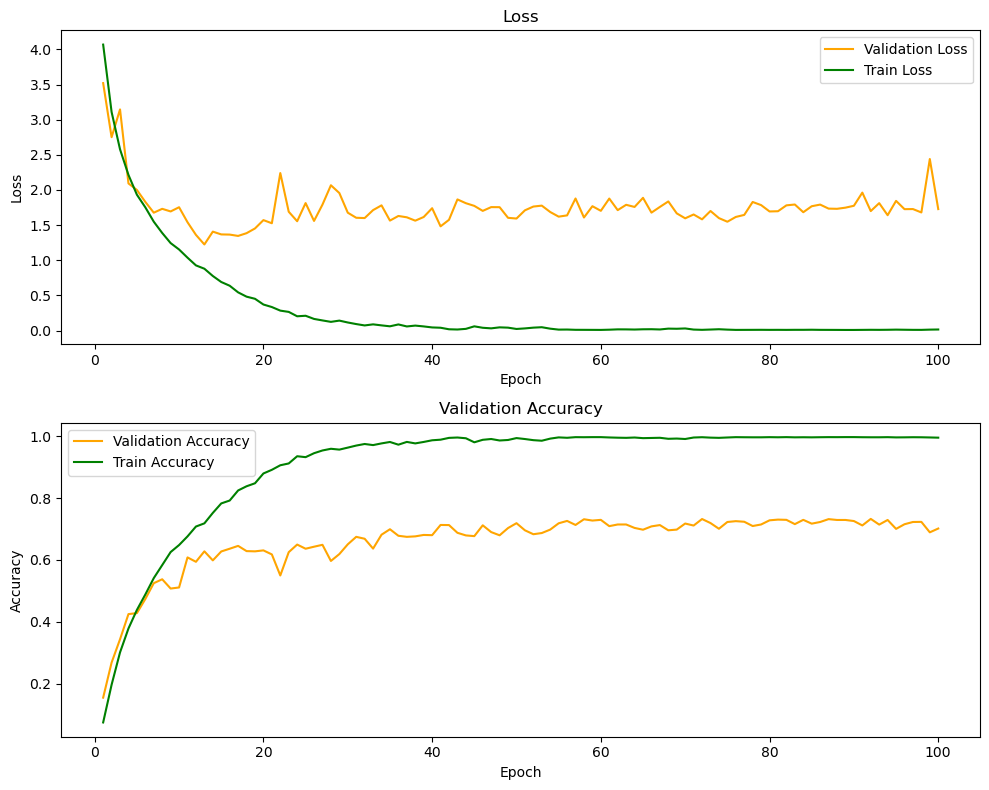

In [102]:
plot_loss_acc(val_loss_array, val_acc_array, train_loss_array, train_acc_array)

## Autoencoder

# Test on validation data

In [20]:
X_val = torch.tensor(val_images, dtype=torch.float32).to('cuda')
X_val = X_val.permute((0, 3, 2, 1))

y_val = torch.tensor(val_labels, dtype=torch.int64)

/tmp/ipykernel_44/765930203.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(val_images, dtype=torch.float32).to('cuda')
/tmp/ipykernel_44/765930203.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(val_labels, dtype=torch.int64)


In [16]:
model2 = ResNet(Block, [2, 2, 2]).to("cuda")
model2.load_state_dict(torch.load('weights/resnet_SGD_momentum=0.75_lr=0.026_2-2-2-blocks_epoch101.pth'))


<All keys matched successfully>

In [17]:
def predict_from_test_data(model, images_path):
    images_paths = os.listdir(images_path)
    images = []
    filenames = []
    for filename in tqdm(images_paths, desc = "Reading images"):
        if filename.endswith(".png"):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img) / 255
            images.append(img_array)
            filenames.append(filename)
    images = np.array(images)
    images_tensor = torch.Tensor(images)
    # images_tensor = torch.tensor(images, dtype=torch.float32).to('cuda')
    images_tensor = images_tensor.permute((0, 3, 2, 1))
    dataset = TensorDataset(images_tensor)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()  # Set the model to evaluation mode
    model.to("cuda")
    
    all_predictions = []
    with torch.no_grad():  # Disable gradient computation during prediction
        for inputs in data_loader:            
            inputs = inputs[0].to('cuda')  # Move input data to GPU
            outputs = model(inputs)
    
            predictions = torch.argmax(outputs, dim=1).float()
            all_predictions.append(predictions.cpu().numpy())

    return filenames, all_predictions

In [18]:
images_names_val, predicted_labels_val =  predict_from_test_data(model2, "val_images")

Reading images: 100%|██████████| 2000/2000 [00:00<00:00, 2568.00it/s]


In [21]:
f1 = f1_score(y_val, predicted_labels_val, average='macro')  # 'weighted' takes class imbalance into account

print(f'Test F1 Score: {f1:.4f}')

Test F1 Score: 0.8021


# Predict test data

In [22]:
images_names_test, predicted_labels_test =  predict_from_test_data(model2, "test_images")

Reading images: 100%|██████████| 5000/5000 [00:52<00:00, 95.40it/s] 


In [23]:
predicted_labels_test_array = [int(x[0]) for x in predicted_labels_test]

In [25]:
data = list(zip(images_names_test, predicted_labels_test_array))

# Specify the CSV file path
csv_file_path = "predictions5.csv"

# Write data to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(['Image', 'Class'])
    
    # Write the data
    writer.writerows(data)

print(f"CSV file '{csv_file_path}' has been successfully created.")

CSV file 'predictions5.csv' has been successfully created.


## idk

In [26]:
from collections import Counter

count = Counter(predicted_labels_test_array)
deviations = [abs(value - 50) for value in count.values()]

sum(deviations)


436

In [ ]:
pred2_sgd - 436 - 76.225 
pred3 (93) - 426 - 75.932
89 - 474
79 - 452
67 - 494
60 - 476
